### slab机制

#### 为什么要引入slab机制

Buddy提供了以page为单位的内存分配接口，这对内核来说颗粒度还太大了，所以需要一种新的机制，将page拆分为更小的单位来管理。

Linux内存以页为单位进行内存管理，buddy算法以2的n次方个页面来进行内存分配管理，最小为2的0次方，也就是一页，最大为2的11次方，就是4MB大小的连续内存空间。但是页的粒度还是太大，Linux下是4KB大小，也就是4096个字节，而kernel本身有很多数据结构时时刻刻都需要分配或者释放，这些数据的大小又往往小于4KB大小，一般只有几个几十个字节这样的大小。
比方最常用到的task_struct（进程描述符）结构体和mm_struct（内存描述符）结构体，其中，izeof task_struct = 9152,sizeof mm_struct = 2064。

task_struct稍微大一点将近2个页面，mm_struct就只有差不多半个页面了。这样一来如果所有的这些数据结构都按照页来分配存储和管理，那么我相信kernel过不了多久自己就玩完了，内存碎片肯定一堆一堆。

所以，引入slab分配器是为了弥补内存管理粒度太大的不足。

#### slab能解决什么问题

slab分配需要解决的是内存的内部碎片问题。
所谓**内部碎片**就是指被内核分配出去但是不能被利用的内存。而**外部碎片**是指由于频繁地申请和释放页框而导致的某些小的连续页框，比方只有一个页框，无法分配给需要大的连续页框的进程而导致的内存碎片。

比如我需要一个100字节的连续物理内存，那么内核slab分配器会给我提供一个相应大小的连续物理内存单元，为128字节大小(不会是整好100字节，而是这个档的一个对齐值，如100字节对应128字节，30字节对应32字节，60字节对应64字节)。

slab分配器会为每一个size分配一个slab，slab的大小是固定的，如128字节，256字节，512字节，1024字节，2048字节，4096字节等。

#### 核心思想

```c
kmem_cache： 内存池
slab：       内存池从系统申请内存的基本单位
object：     内存池提供的内存的单位
```
**slab核心思想：对象管理内存（简单说：就是你经常用什么我先给你创造一堆出来，你要用直接拿，不用放回来）**

使用对象的概念来管理内存。

slab分配器的基本思想是，先利用页面分配器分配出单个或者一组连续的物理页面，然后在此基础上将整块页面分割成多个相等的**小内存单元**，以满足小内存空间分配的需要。当然，为了有效的管理这些小的内存单元并保证极高的内存使用速度和效率。

在内核中，经常会使用一些链表，链表中会申请许多相同结构的结构体，比如文件对象，进程对象等等，如果申请比较频繁，那么为它们建立一个内存池，内存池中都是相同结构的结构体，当想申请这种结构体时，直接从这种内存池中取一个结构体出来，是有用且速度极快的。一个物理页就可以作用这种内存池的载体，进而进行充分利用，减少了内部碎片的产生。

所以，Slab 相当于内存池思想，且是为了解决内碎片而产生的，slab的核心思想是以对象的观点管理内存。

所谓的对象就是存放一组数据结构的内存区，为便于理解可把对象看作内核中的数据结构（例如：task_struct,file_struct 等）。

相同类型的对象归为一类，每当要申请这样一个对象时，slab分配器就从一个slab列表中分配一个这样大小的单元出去，而当要释放时，将其重新保存在该列表中，而不是直接返回给伙伴系统，从而避免内部碎片。

#### slab分配的最小和最大内存单元是多少?

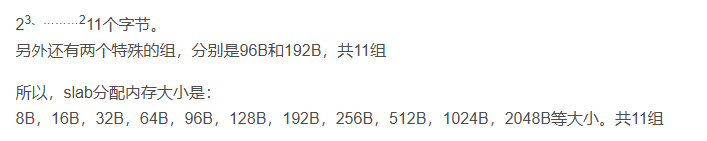

#### slab和/proc

proc 文件系统提供了一种简单的方法来监视系统中所有活动的 slab 缓存。这个文件称为 /proc/slabinfo，它除了提供一些可以从用户空间访问的可调整参数之外，还提供了有关所有 slab 缓存的详细信息。

```c
[root@localhost home]# cat  /proc/slabinfo
slabinfo - version: 2.1
# name            <active_objs> <num_objs> <objsize> <objperslab> <pagesperslab> : tunables <limit> <batchcount> <sharedfactor> : slabdata <active_slabs> <num_slabs> <sharedavail>
nf_conntrack_ffffffffb58fc900     51     51    320   51    4 : tunables    0    0    0 : slabdata      1      1      0
rpc_inode_cache       51     51    640   51    8 : tunables    0    0    0 : slabdata      1      1      0
xfs_dqtrx              0      0    528   62    8 : tunables    0    0    0 : slabdata      0      0      0
xfs_dquot              0      0    488   67    8 : tunables    0    0    0 : slabdata      0      0      0
xfs_ili             2016   2016    168   48    2 : tunables    0    0    0 : slabdata     42     42      0
xfs_inode          21182  21182    960   34    8 : tunables    0    0    0 : slabdata    623    623      0
xfs_efd_item          39     39    416   39    4 : tunables    0    0    0 : slabdata      1      1      0
xfs_btree_cur         39     39    208   39    2 : tunables    0    0    0 : slabdata      1      1      0
……
```

#### slab创建流程

那什么时候会创建一个slab呢？只有满足下面两个条件时，才会给 kmem_cache 分配Slab：

```c
（1）已发出一个分配新对象的请求；
（2）kmem_cache 中没有了空闲对象；
```

其实本质就是：
*  需要得到该 kmem_cache 下一个对象，而kmem_cache没有空闲对象，这时候就会给kmem_cache分配一个slab了。
*  所以新分配的kmem_cache只有被要求分配一个对象时，才会调用函数去申请物理页；
具体的分配流程：

```c
首先会调用 kmem_cache_grow（）函数给kmem_cache分配一个新的Slab。
其中，该函数调用kmem_gatepages()从伙伴系统获得一组连续的物理页面
然后又调用kmem_cache_slabgmt()获得一个新的Slab结构
还要调用kmem_cache_init_objs()为新Slab中的所有对象申请构造方法
最后，调用kmem_slab_link_end()把这个Slab结构插入到缓冲区中Slab链表的末尾
```


#### kmalloc函数本质

kmalloc 是循环遍历可用缓存来查找可以满足大小限制的缓存。找到之后，就（使用 kmem_cache_alloc ）分配一个对象。

```c
void * kmalloc(size_t size, int flags)
{
	struct cache_size *csizep = malloc_sizes; //1. 定义好大小的数组
	struct kmem_cache *cachep;

	/* 2. 这是关键，从 malloc_sizes 数组（其实也是从kmem_cache链表)中遍历,
	   得到地一个大于等于size的cache */
	while(size > csizep->cs_size)
		csizep++;

	cachep = csizep->cs_cachep;
	
	// 3.这里会发现正真分配对象的还是靠 kmem_cache_alloc()函数
	return kmem_cache_alloc(cachep, flags)
}
```